<a href="https://colab.research.google.com/github/ChristianConchari/Computer-Vision-Notes/blob/master/Tutorial_18_Feature_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 18: Feature Visualization

Due to the massive growth of CNNs and their applications, many researchers argued that these not only need to have better accuracy but also more interpretability. After all, CNNs should not be  black-boxes that receive an image and output a magic result. Consequently, many research projects focused on providing meaningful information about the learning process of CNNs, an area currently known as Feature Visualization. 

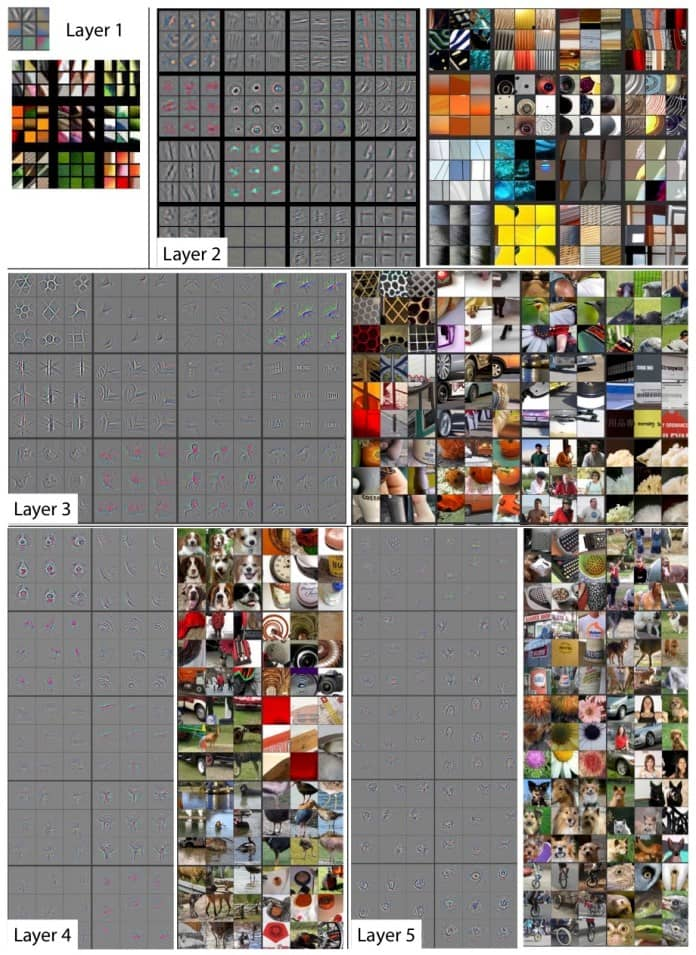

For this tutorial, we will se some strategies to visualise the features learn through the CNN implemented in Tutorial 17, so feature visualisation starts in section 5. 

## 1. Import libraries and the dataset. Display samples. 

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)

# print details of the imported subsets
print("Trainset: ",train_data)
print("Testset: ",test_data)

# prepare data loaders, set the batch_size
# consider changing the batch size because this can also have effects in the 
# accuracy of your CNN
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!
Trainset:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Testset:  Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize an entire batch 

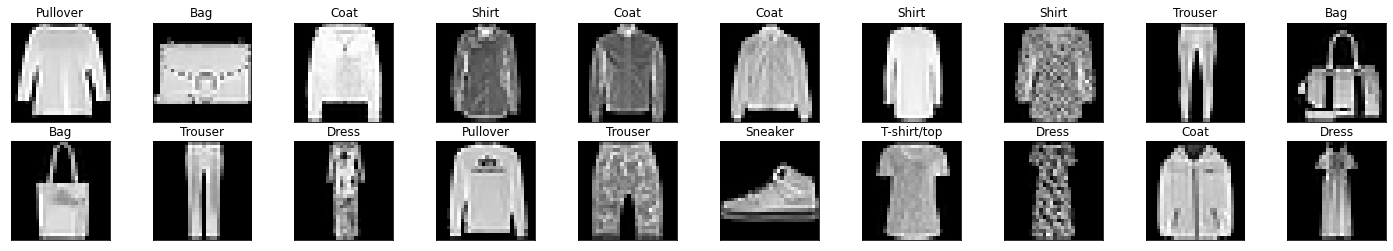

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## 2. Define the network architecture

The various layers that make up any neural network are documented [here](http://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

Similarly as you did with neural networks, you define the layers of a CNN model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. 

Recommendations/tips:
* Use at least two convolutional layers
* Your output must be a linear layer with 10 outputs (for the 10 classes of clothing)
* Use a dropout layer to avoid overfitting


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #(1,28,28)
        # 1 input image channel (grayscale), 32 output channels/feature maps
        # 3x3 square convolution kernel
        # W -> Width
        # F -> Filter
        # S -> Stride
        ## output size = (W-F)/S + 1 = (28-3)/1 + 1 = 26
        # the output Tensor for one image, will have the dimensions: (32, 26, 26)
        # after one pool layer, this becomes (32, 13, 13)
        self.conv1 = nn.Conv2d(1, 32, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 32 inputs, 64 outputs, 3x3 conv
        # output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (64, 11, 11)
        # after another pool layer this becomes (64, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(32, 64, 3)

        # third conv layer: 64 inputs, 128 outputs, 3x3 conv
        # output size = (W-F)/S +1 = (5-3)/1 + 1 = 3
        # the output tensor will have dimensions: (128, 3, 3)
        # after another pool layer this becomes (128, 1, 1)
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        # 128 outputs the 1*1 filtered/pooled map size
        self.fc1 = nn.Linear(128*1*1, 64)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.3)
        
        # create 32 output channels layer
        self.fc2 = nn.Linear(64, 32)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc3 = nn.Linear(32, 10)
        

    # define the feedforward behavior
    def forward(self, x):
        # three conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = self.fc1_drop(F.relu(self.fc1(x)))
        x = self.fc1_drop(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc1_drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
import torch.optim as optim

# define a loss function
criterion = nn.NLLLoss()
# stochastic gradient descent with a small learning rate AND some momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 3. Train the network

In [ ]:
# this time we will define a function which takes in a number of epochs to train for. 
# this function return the total loss over time, which you can visualize if needed
def train(n_epochs):
    
    # to track the loss as the network trains
    loss_over_time = [] 
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs):  
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print("Epoch: ",epoch + 1," Batch:",batch_i+1, "Avg. Loss: ",avg_loss  )
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

# define the number of epochs to train for
n_epochs = 25

# call train
training_loss = train(n_epochs)


Epoch:  1  Batch: 1000 Avg. Loss:  2.302493288755417
Epoch:  1  Batch: 2000 Avg. Loss:  2.282196034908295
Epoch:  1  Batch: 3000 Avg. Loss:  1.7192394731640817
Epoch:  2  Batch: 1000 Avg. Loss:  1.2163234177827835
Epoch:  2  Batch: 2000 Avg. Loss:  1.1040771474838258
Epoch:  2  Batch: 3000 Avg. Loss:  1.0143150347471237
Epoch:  3  Batch: 1000 Avg. Loss:  0.9210167255103588
Epoch:  3  Batch: 2000 Avg. Loss:  0.860325844079256
Epoch:  3  Batch: 3000 Avg. Loss:  0.8180922945141792
Epoch:  4  Batch: 1000 Avg. Loss:  0.7634789886474609
Epoch:  4  Batch: 2000 Avg. Loss:  0.751701396137476
Epoch:  4  Batch: 3000 Avg. Loss:  0.7311816098541022
Epoch:  5  Batch: 1000 Avg. Loss:  0.7030220677852631
Epoch:  5  Batch: 2000 Avg. Loss:  0.672803216829896
Epoch:  5  Batch: 3000 Avg. Loss:  0.6767395927011967
Epoch:  6  Batch: 1000 Avg. Loss:  0.6416069389879704
Epoch:  6  Batch: 2000 Avg. Loss:  0.6349832812547683
Epoch:  6  Batch: 3000 Avg. Loss:  0.6310590842217207
Epoch:  7  Batch: 1000 Avg. Loss:

## 4. Evaluate the model


In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss:',test_loss.numpy()[0])

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of ',classes[i],':', 100 * class_correct[i] / class_total[i],'%')
    else:
        print('Test Accuracy of ',classes[i],': No training examples')


Test Loss: 0.35546976
Test Accuracy of  T-shirt/top : 85.5 %
Test Accuracy of  Trouser : 96.9 %
Test Accuracy of  Pullover : 85.7 %
Test Accuracy of  Dress : 91.0 %
Test Accuracy of  Coat : 80.7 %
Test Accuracy of  Sandal : 97.2 %
Test Accuracy of  Shirt : 51.6 %
Test Accuracy of  Sneaker : 94.0 %
Test Accuracy of  Bag : 96.8 %
Test Accuracy of  Ankle boot : 96.0 %


### Visualize a sample test result

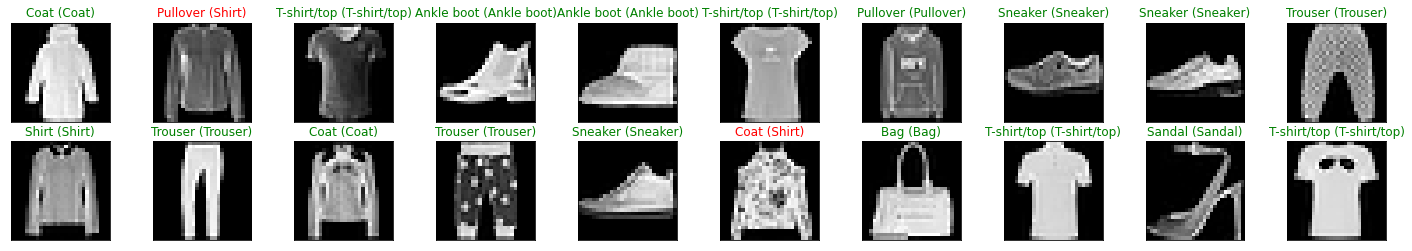

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(""+str(classes[preds[idx]])+" ("+str(classes[labels[idx]])+")",color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
# set the module to evaluation mode
net.eval()
total_predictions = 0
correct_predictions = 0
for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for all the object class
    for i in range(batch_size):
        correct_predictions += correct[i].item()
        total_predictions += 1

print(f'Test Accuracy of the model with {total_predictions} elements and {correct_predictions} correct predictions: {round(100 * correct_predictions / total_predictions,2)}%')

Test Accuracy of the model with 10000 elements and 8754 correct predictions: 87.54%


## 5. Feature Visualization

First, let's extract and display some generated filters in the first convolutional layer. Consider the patterns of light and dark pixels, can you tell what kind of patter they detect?

First convolutional layer


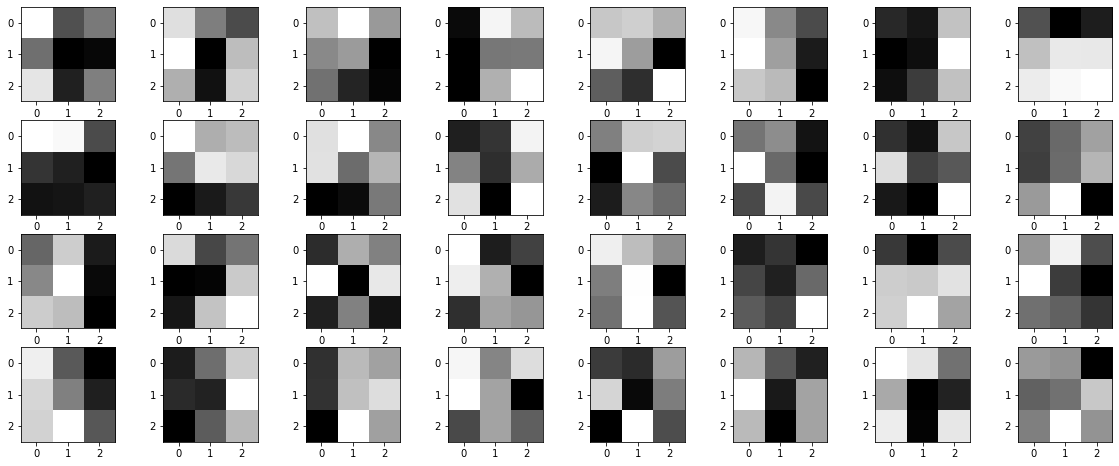

In [ ]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 8
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

Next, you can apply these filters to an image sample with the `filter2D` function to see the activation behaviour. The result images are also known as **activation maps**. We'll do this for the first and second convolutional layers and these activation maps should really give you a sense for what features each filter learns to extract.

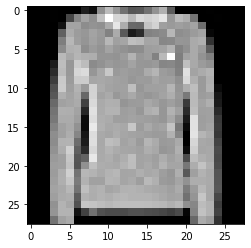

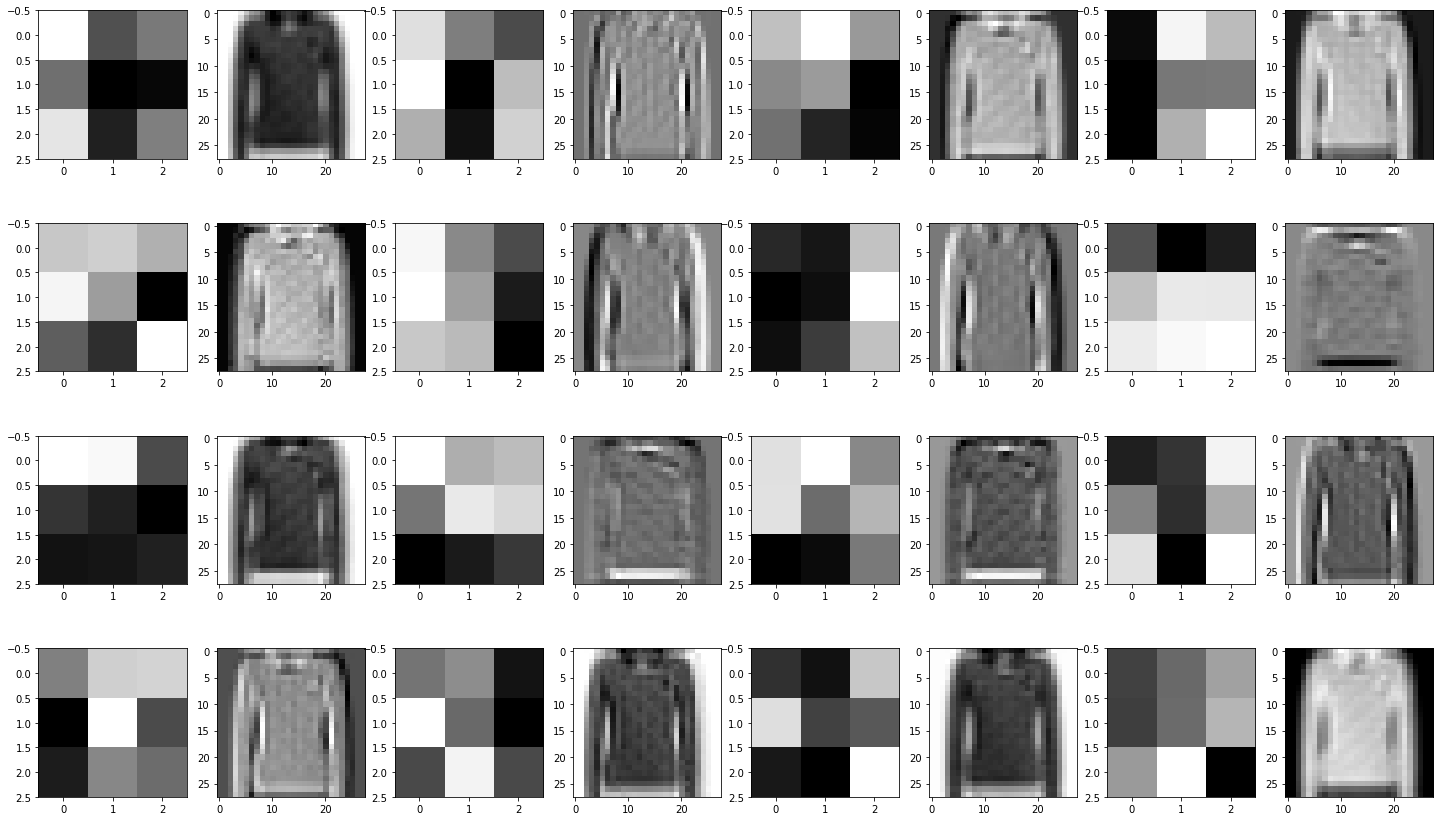

In [ ]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 3
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 32 filters
fig=plt.figure(figsize=(25, 15))
columns = 8
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

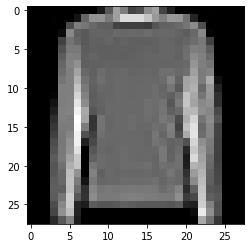

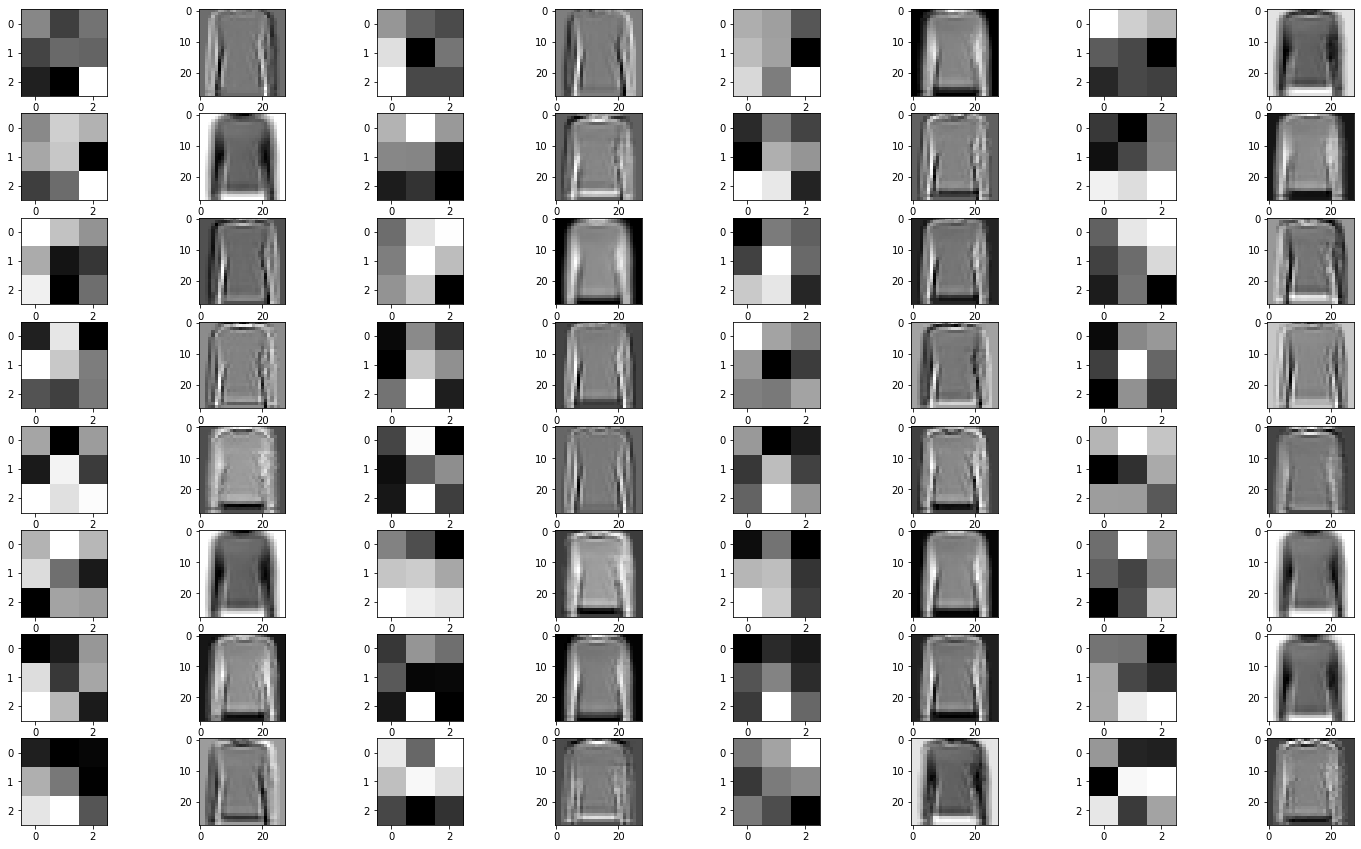

In [ ]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 64 filters
fig=plt.figure(figsize=(25, 15))
columns = 8
rows = 8
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

## Exercise 1: 

For this exercise, you'll have to include one or two new convolutional layers and display display the activation maps similarly as the last cells. Looking at these new activations, what purpose do you think they play? What kind of feature do you think they detect?

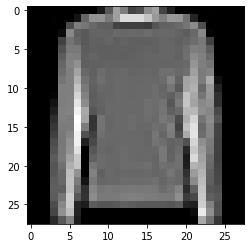

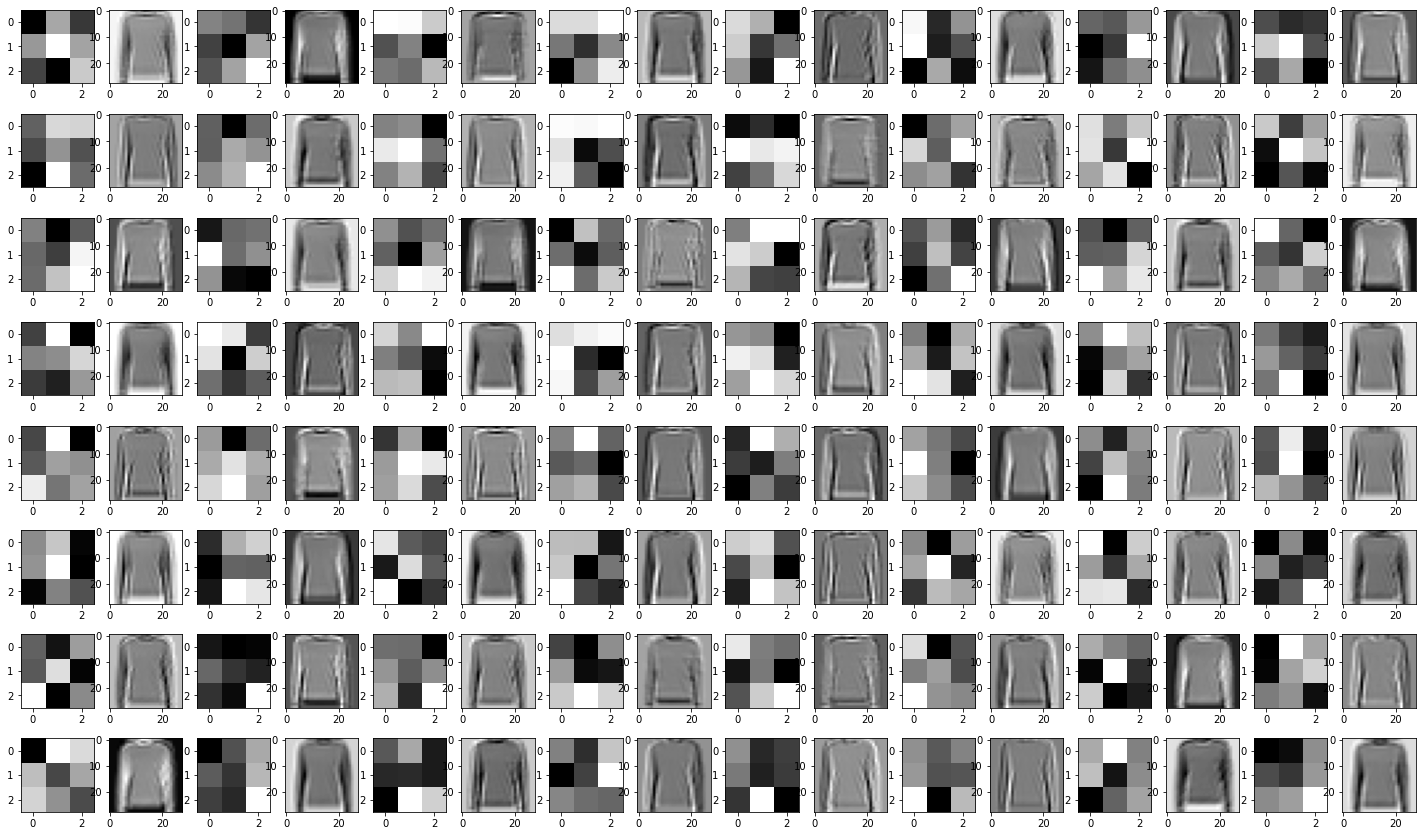

In [ ]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv3
weights = net.conv3.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(25, 15))
columns = 16
rows = 8
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

As we know the main purpose of the convolutional layers is to filter the images in order to extract the most important or relevant features, and in the same way reduce the amount of information by polling, being that each time we will be left with only the most relevant features of an image. 

The architecture used to solve this tutorial is the following:

Net:
  - (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  - (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  - (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  - (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  - (fc1): Linear(in_features=128, out_features=64, bias=True)
  - (fc1_drop): Dropout(p=0.3, inplace=False)
  - (fc2): Linear(in_features=64, out_features=32, bias=True)
  - (fc3): Linear(in_features=32, out_features=10, bias=True)

As we can see, 3 convolutional layers are being used, for the first one we will have as input the tensor (1,28,28) and output the tensor (32,13,13). This tensor will be the input of a second layer, whose output will be another tensor (64,5,5), which finally will be the input of a next layer, whose output will be a tensor of size (128,1,1), which can be seen as a vector that contains the most relevant information of the input image and will be ready to pass the linear layers. As we can see in the images shown in the upper cell, the main purpose of these activations is to filter the information. 

Finally, from the convolution examples obtained we can think that the features we are looking for are related to contours and corners. Ultimately, though, it is difficult to say what specific features each filter is looking for at the time of convolution, as this will depend on the training of the network.


